In [148]:
import pandas as pd
import numpy as np
order = pd.read_csv("olist_orders_dataset.csv")
item = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
customer = pd.read_csv("olist_customers_dataset.csv")
product = pd.read_csv("product_category_name_translation.csv")

In [149]:
order.head()
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


# Data Cleaning and Preparing

In [150]:
order.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


### 📌 Raw order data contained incorrect data types, missing timestamps, and potential duplicates, which could lead to inaccurate time-based insights.

### identifying missing values

In [151]:
order.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [153]:
order[order['order_delivered_customer_date'].isnull()]['order_status'].value_counts()

order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: count, dtype: int64

### 📌 Documentation:
* Missing timestamps were retained as they represent incomplete or failed order lifecycles and carry business meaning

### removing duplicates

In [154]:
order.duplicated().sum()

np.int64(0)

### 📌 Documentation:
* Checked and removed duplicate order records to avoid double counting during analysis.

### converting the date column

In [155]:
date_col = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
]


In [156]:
for col in date_col:
    order[col] = pd.to_datetime(order[col], errors='coerce')    

### 📌 Documentation:
* Converted all timestamp columns to datetime format to enable accurate delivery time and delay calculations.

## Fix data types & consistency checks

In [157]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [158]:
order['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

### 📌 Documentation:
* Validated categorical consistency in order_status to ensure reliable segmentation.

# feature enginerring

* finding Delivery Time

In [159]:
order['delivery_time_date']=(
    order['order_delivered_customer_date']-
    order['order_purchase_timestamp']
).dt.days

In [160]:
order.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.0


* finding Shipping Date

In [161]:
order['Shipping_delay_date']=(
    order['order_delivered_carrier_date']-
    order['order_approved_at']
).dt.days

In [162]:
df_new_clmn = order.rename(columns = {"Shipping_delay_date":"Shipping_delay_days", "delivery_time_date":"Delivery_time_days"}, inplace='True')

* Late Delivery Flag

In [163]:
order['is_late_delivery']=(
    order['order_delivered_customer_date']>
    order['order_estimated_delivery_date']
)

In [164]:
order['is_late_delivery'].value_counts()

is_late_delivery
False    91614
True      7827
Name: count, dtype: int64

In [165]:
order['is_late_delivery'].mean()*100

np.float64(7.870998883760219)

### 📌 Documentation:
* Created derived features such as delivery time, shipping delay, and late delivery flag to support operational performance analysis.

# Identifying outliers

In [166]:
order['Delivery_time_days'].describe()

count    96476.000000
mean        12.094086
std          9.551746
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: Delivery_time_days, dtype: float64

In [167]:
orders = order[order['Delivery_time_days']>=0]

### 📌 Documentation:
* Removed logically invalid records such as negative delivery durations caused by timestamp inconsistencies.

# Data Cleaning Summary

* Identified and analyzed missing values across order lifecycle stages
* Retained missing timestamps linked to canceled or incomplete orders
* Removed duplicate records
* Converted timestamp columns to datetime format
* Engineered delivery and delay-related features
* Handled logically invalid delivery durations

# 📊Order Funnel Analysis

❓ Out of all orders placed, how many successfully reach the customer — and where do we lose orders?

* This help to identify the operational leakage by tracking how many orders progess through each stage of the order lifecycle

In [168]:
order['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [169]:
total_orders = order['order_id'].nunique()
total_orders

99441

In [170]:
order_status_counts = order['order_status'].value_counts().reset_index()
order_status_counts.columns= ['order_status', 'order_count']
order_status_counts

,order_status,order_count
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


In [171]:
order_status_counts['percentage'] = (
    order_status_counts['order_count'] / total_orders * 100
).round(2)

order_status_counts

,order_status,order_count,percentage
0,delivered,96478,97.02
1,shipped,1107,1.11
2,canceled,625,0.63
3,unavailable,609,0.61
4,invoiced,314,0.32
5,processing,301,0.30
6,created,5,0.01
7,approved,2,0.00


* Delivered VS Not Delivered

In [172]:
order['delivery_success'] = order['order_status'].apply(
    lambda x: 'Delivered' if x == 'delivered' else 'Not Delivered'
)
order['delivery_success'].value_counts(normalize =True)*100

delivery_success
Delivered        97.020344
Not Delivered     2.979656
Name: proportion, dtype: float64

### 🔍 Order Status Distribution & Funnel Analysis

The majority of orders (97.02%) were successfully delivered, indicating a strong fulfillment performance.
However, approximately 2.97% of orders failed to reach customers due to cancellations, unavailability, or processing delays.
These drop-offs represent operational leakage points that can impact customer satisfaction and revenue.


* Funnel Visualization 

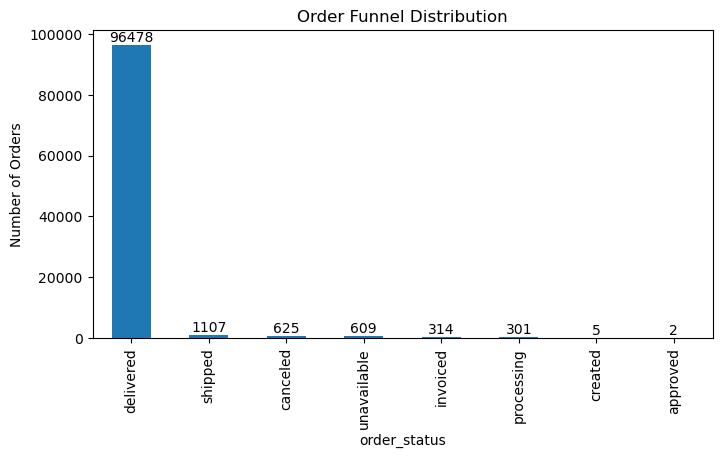

In [173]:
import matplotlib.pyplot as plt

ax = order_status_counts.set_index('order_status')['order_count'].plot(
    kind='bar',title='Order Funnel Distribution', figsize =(8,4)
)
plt.ylabel('Number of Orders')

for container in ax.containers:
    ax.bar_label(container, fmt='%d')
    
plt.show()

# 📌 Business Recommendations

* Investigate root causes behind canceled and unavailable orders
* Improve inventory and logistics coordination
* Prioritize high-risk stages to reduce order leakage

### Order Funnel Summary

* Analyzed order lifecycle stages using order_status
* Calculated delivery success and failure rates
* Identified operational leakage points before final delivery
* Provided actionable insights to improve fulfillment efficiency

# 🚚Delivery Time & Delay Analysis

❓ How fast are we delivering orders, and where are delays happening?

* Delivery time directly impacts customer satisfaction, repeat purchases, and operational efficiency.

* avg and median delivery time

In [174]:
order['Delivery_time_days'].describe()

count    96476.000000
mean        12.094086
std          9.551746
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: Delivery_time_days, dtype: float64

* Delivery time by order Status

In [175]:
order.groupby('order_status')['Delivery_time_days'].agg( ['count', 'mean','median']).sort_values('mean')

,count,mean,median
order_status,,,
delivered,96470,12.093604,10.0
canceled,6,19.833333,20.0
approved,0,NaN,NaN
created,0,NaN,NaN
invoiced,0,NaN,NaN
processing,0,NaN,NaN
shipped,0,NaN,NaN
unavailable,0,NaN,NaN


In [176]:
order['Shipping_delay_days'].describe()

count    97644.000000
mean         2.301749
std          3.560283
min       -172.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: Shipping_delay_days, dtype: float64

In [177]:
order.groupby('order_status')['Shipping_delay_days'].median()

order_status
approved       NaN
canceled       2.0
created        NaN
delivered      1.0
invoiced       NaN
processing     NaN
shipped        2.0
unavailable    NaN
Name: Shipping_delay_days, dtype: float64

* checking negative value

In [190]:
order[order['Shipping_delay_days'] < 0]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Delivery_time_days,Shipping_delay_days,is_late_delivery,delivery_success
15,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04,13.0,-2.0,False,Delivered
64,688052146432ef8253587b930b01a06d,81e08b08e5ed4472008030d70327c71f,delivered,2018-04-22 08:48:13,2018-04-24 18:25:22,2018-04-23 19:19:14,2018-04-24 19:31:58,2018-05-15,2.0,-1.0,False,Delivered
199,58d4c4747ee059eeeb865b349b41f53a,1755fad7863475346bc6c3773fe055d3,delivered,2018-07-21 12:49:32,2018-07-26 23:31:53,2018-07-24 12:57:00,2018-07-25 23:58:19,2018-07-31,4.0,-3.0,False,Delivered
210,412fccb2b44a99b36714bca3fef8ad7b,c6865c523687cb3f235aa599afef1710,delivered,2018-07-22 22:30:05,2018-07-23 12:31:53,2018-07-23 12:24:00,2018-07-24 19:26:42,2018-07-31,1.0,-1.0,False,Delivered
415,56a4ac10a4a8f2ba7693523bb439eede,78438ba6ace7d2cb023dbbc81b083562,delivered,2018-07-22 13:04:47,2018-07-27 23:31:09,2018-07-24 14:03:00,2018-07-28 00:05:39,2018-08-06,5.0,-4.0,False,Delivered
...,...,...,...,...,...,...,...,...,...,...,...,...
99091,240ead1a7284667e0ec71d01f80e4d5e,fcdd7556401aaa1c980f8b67a69f95dc,delivered,2018-07-02 16:30:02,2018-07-05 16:17:59,2018-07-05 14:11:00,2018-07-10 23:21:47,2018-07-24,8.0,-1.0,False,Delivered
99230,78008d03bd8ef7fcf1568728b316553c,043e3254e68daf7256bda1c9c03c2286,delivered,2018-07-03 13:11:13,2018-07-05 16:32:52,2018-07-03 12:57:00,2018-07-10 17:47:39,2018-07-23,7.0,-3.0,False,Delivered
99266,76a948cd55bf22799753720d4545dd2d,3f20a07b28aa252d0502fe7f7eb030a9,delivered,2018-01-30 02:41:30,2018-02-04 23:31:46,2018-01-31 18:11:58,2018-03-18 20:08:50,2018-03-02,47.0,-5.0,True,Delivered
99377,a6bd1f93b7ff72cc348ca07f38ec4bee,6d63fa86bd2f62908ad328325799152f,delivered,2018-04-20 17:28:40,2018-04-24 19:26:10,2018-04-23 17:18:40,2018-04-28 17:38:42,2018-05-15,8.0,-2.0,False,Delivered


In [191]:
order[order['Shipping_delay_days'] < 0]['order_status'].value_counts()

order_status
delivered    1350
shipped         9
Name: count, dtype: int64

* check outliers

In [179]:
order[order['Shipping_delay_days'] > order['Shipping_delay_days'].quantile(0.99)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Delivery_time_days,Shipping_delay_days,is_late_delivery,delivery_success
41,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,33.0,18.0,True,Delivered
288,9f882c1f904b7dd156572ada58d7a7ae,843ff05b30ce4f75b6170b39c78a8ee5,delivered,2017-11-13 10:07:36,2017-11-13 10:16:29,2017-12-01 23:19:42,2017-12-11 17:38:06,2017-12-22,28.0,18.0,False,Delivered
670,16cb3a72f04e248a1244b076ce0d9bb7,ff9c535af2f9325df8f3c81f30f60b8b,delivered,2018-05-23 14:21:17,2018-05-23 14:37:15,2018-06-11 09:07:00,2018-06-19 18:50:58,2018-07-05,27.0,18.0,False,Delivered
755,4190ab61a7fced69f3ee84d1da1120cc,3df7ff0b86935d5249e4d6cd56b89131,delivered,2017-12-08 11:38:00,2017-12-09 02:36:21,2018-01-12 00:35:33,2018-01-31 19:08:40,2018-01-11,54.0,33.0,True,Delivered
757,a06c43ed81f5c604287461f4d21949ce,da82d24c21654f951fedc813df8a5dc6,delivered,2017-10-24 17:39:10,2017-10-24 17:56:20,2017-11-20 21:15:00,2017-11-23 21:48:41,2017-11-17,30.0,27.0,True,Delivered
...,...,...,...,...,...,...,...,...,...,...,...,...
98594,099acf2a98eba9bab889af025be407b7,7c2a55810a39cd8421f6fd48f88210ac,delivered,2017-08-15 13:24:17,2017-08-16 03:10:33,2017-09-06 16:04:46,2017-09-06 16:04:47,2017-10-18,22.0,21.0,False,Delivered
98788,04f352fa3f3b02bb7c523906d577c4b8,7d330f9363872d46a4d38361586876a9,delivered,2017-11-11 19:03:58,2017-11-11 19:15:27,2017-11-30 18:34:30,2017-12-08 16:22:17,2017-12-14,26.0,18.0,False,Delivered
99017,a0224d0bc0030c9226e9613d6561a7aa,278c63ede99698eb4838f0df378d9adf,delivered,2018-05-09 23:19:02,2018-05-09 23:33:32,2018-05-29 12:28:00,2018-06-11 22:18:38,2018-06-19,32.0,19.0,False,Delivered
99035,7e2dddf174cc4d2768bf39c43ab2bd7a,accfbaa1f092fdf6db1d8fcdad351b50,delivered,2016-10-09 15:10:41,2016-10-10 05:54:51,2016-11-03 07:43:55,2016-11-10 09:27:42,2016-12-02,31.0,24.0,False,Delivered


* Analysis revealed 1,359 orders with negative shipping delivery days, including delivered orders, which is logically impossible. These anomalies were treated as data quality issues and removed to ensure accuracy of delivery performance analysis.

In [193]:
order = order[order['Shipping_delay_days'] >= 0]

order

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Delivery_time_days,Shipping_delay_days,is_late_delivery,delivery_success
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0,2.0,False,Delivered
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.0,0.0,False,Delivered
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.0,0.0,False,Delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.0,3.0,False,Delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2.0,0.0,False,Delivered
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,8.0,1.0,False,Delivered
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,22.0,1.0,False,Delivered
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,24.0,1.0,False,Delivered
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,17.0,3.0,False,Delivered


In [195]:
order['Shipping_delay_days'].describe()

count    96285.000000
mean         2.359090
std          3.506244
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: Shipping_delay_days, dtype: float64

In [198]:
order[order['Shipping_delay_days'] < 0].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Delivery_time_days,Shipping_delay_days,is_late_delivery,delivery_success


* Verified raw records before removal.

In [199]:
order.groupby('order_status')['Shipping_delay_days'].median()

order_status
canceled     2.0
delivered    1.0
shipped      2.0
Name: Shipping_delay_days, dtype: float64

<Axes: >

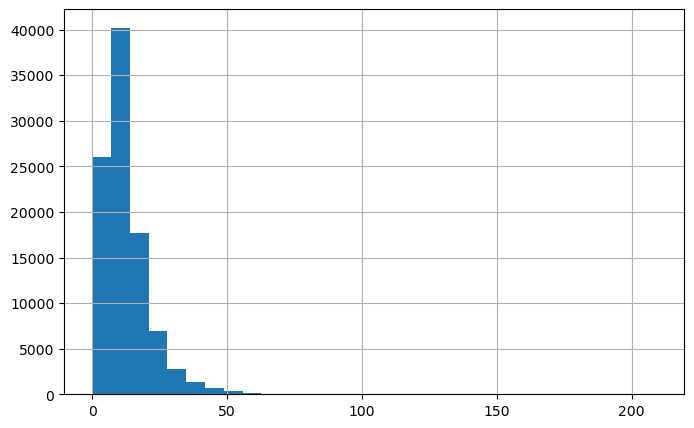

In [201]:
orders['Delivery_time_days'].hist(bins=30, figsize=(8,5))

* Segment deliveries into buckets

In [205]:
order['delivery_speed'] = pd.cut(
    orders['Delivery_time_days'],
    bins=[0,5,10,20,50,100],
    labels=['very_fast','fast','normal','slow','very_slow']
)

In [206]:
order['delivery_speed'].value_counts(normalize= True) *100

delivery_speed
fast         33.970980
normal       33.276513
very_fast    19.718636
slow         12.461462
very_slow     0.572409
Name: proportion, dtype: float64

* Identify delay-prone orders

In [211]:
order[order['Delivery_time_days']>order['Delivery_time_days']].quantile(0.95)

order_id                         NaN
customer_id                      NaN
order_status                     NaN
order_purchase_timestamp         NaT
order_approved_at                NaT
order_delivered_carrier_date     NaT
order_delivered_customer_date    NaT
order_estimated_delivery_date    NaT
Delivery_time_days               NaN
Shipping_delay_days              NaN
is_late_delivery                 NaN
delivery_success                 NaN
delivery_speed                   NaN
Name: 0.95, dtype: object

### Delivery Performance Summary

* Analyzed average, median, and extreme delivery times
* Identified shipping delays as a major contributor
* Segmented delivery speeds into business-friendly categories
* Highlighted operational risks caused by long-tail delays

In [214]:
order.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'Delivery_time_days', 'Shipping_delay_days', 'is_late_delivery',
       'delivery_success', 'delivery_speed'],
      dtype='object')

In [215]:
orders.columns = orders.columns.str.lower()

In [217]:
order.columns.str.lower()

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'delivery_time_days', 'shipping_delay_days', 'is_late_delivery',
       'delivery_success', 'delivery_speed'],
      dtype='object')

In [219]:
order['Delivery_time_days'].isnull().sum()

np.int64(1174)

In [220]:
order['Delivery_time_days'].describe()

count    95111.000000
mean        12.151959
std          9.577141
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: Delivery_time_days, dtype: float64

In [223]:
p95= order['Delivery_time_days'].quantile(0.95)
order[order['Delivery_time_days']>p95]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Delivery_time_days,Shipping_delay_days,is_late_delivery,delivery_success,delivery_speed
29,ecab90c9933c58908d3d6add7c6f5ae3,761df82feda9778854c6dafdaeb567e4,delivered,2018-02-25 13:50:30,2018-02-25 14:47:35,2018-02-26 22:28:50,2018-03-27 23:29:14,2018-04-13,30.0,1.0,False,Delivered,slow
35,8563039e855156e48fccee4d611a3196,5f16605299d698660e0606f7eae2d2f9,delivered,2018-02-17 15:59:46,2018-02-17 16:15:34,2018-02-20 23:03:56,2018-03-20 00:59:25,2018-03-20,30.0,3.0,True,Delivered,slow
41,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,33.0,18.0,True,Delivered,slow
97,6a0a8bfbbe700284feb0845d95e0867f,68451b39b1314302c08c65a29f1140fc,delivered,2017-11-22 11:32:22,2017-11-22 11:46:50,2017-11-27 13:39:35,2017-12-28 19:43:00,2017-12-11,36.0,5.0,True,Delivered,slow
110,9d531c565e28c3e0d756192f84d8731f,d4faa220408c20e53595d2950f361f3b,delivered,2017-11-28 21:00:44,2017-12-01 09:31:15,2017-12-14 20:37:43,2018-01-23 21:38:52,2017-12-22,56.0,13.0,True,Delivered,very_slow
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99115,4a4ded48a84c0cee9a190dd22ce96866,2b22da03dd8511de17c84238e49082f9,delivered,2017-12-28 21:32:44,2017-12-29 02:09:39,2018-01-03 15:38:32,2018-02-25 14:54:29,2018-01-30,58.0,5.0,True,Delivered,very_slow
99121,25f6cb0e242a4c0bacc239397614422e,c3e28a954146468597f1dfe3ab014eab,delivered,2017-11-20 12:50:49,2017-11-21 04:06:25,2017-11-27 22:04:13,2017-12-22 19:52:48,2017-12-21,32.0,6.0,True,Delivered,slow
99279,4cf09d9e5ebbe0f91ddd7bf9aae891cd,07b6b4fe5fefb948fc76b6d2bdba77d8,delivered,2018-07-19 08:37:26,2018-07-21 03:25:17,2018-07-23 15:31:00,2018-08-21 01:12:45,2018-08-10,32.0,2.0,True,Delivered,slow
99423,38e9133ce29f6bbe35aed9c3863dce01,ad312389a098ceff46ce92c4595c06d0,delivered,2017-10-12 20:54:11,2017-10-14 03:28:24,2017-10-17 17:04:42,2017-11-21 17:06:59,2017-10-31,39.0,3.0,True,Delivered,slow


# Late Delivery vs Estimated Date Analysis

❓ Are we meeting our promised delivery timelines? If not, how bad is it?

### ⏰ Late Delivery Analysis

* validating required columns

In [225]:
order[['order_delivered_customer_date','order_estimated_delivery_date']].isnull().sum()

order_delivered_customer_date    1174
order_estimated_delivery_date       0
dtype: int64

* calculating the late delivery date

In [230]:
late_delivery_date= (order['is_late_delivery'].value_counts(normalize=True)*100)

late_delivery_date

is_late_delivery
False    91.90632
True      8.09368
Name: proportion, dtype: float64

#### 🔍 Appx. 8.09% of order were shipped late then the estimated delivery date

* Focus only delivered order

In [237]:
delivered_order = order[order['order_status']== 'delivered']

(
    delivered_order['is_late_delivery'].value_counts(normalize = True)*100
)

is_late_delivery
False    91.807553
True      8.192447
Name: proportion, dtype: float64

* How late are the late orders?

In [251]:
delivered_order['late_days'] = (
    delivered_order['order_delivered_customer_date'] -
    delivered_order['order_estimated_delivery_date']
).dt.days

C:\Users\Sakshi\AppData\Local\Temp\ipykernel_15324\1057105354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_order['late_days'] = (


In [256]:
delivered_order['late_days']=delivered_order['late_days'].clip(lower=0)
delivered_order['late_days'].describe()

C:\Users\Sakshi\AppData\Local\Temp\ipykernel_15324\3479575807.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_order['late_days']=delivered_order['late_days'].clip(lower=0)


count    95105.000000
mean         0.727102
std          4.678213
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        188.000000
Name: late_days, dtype: float64

In [257]:
delivered_order['late_severity'] = pd.cut(
    delivered_order['late_days'],
    bins=[0, 1, 3, 7, 15, 60],
    labels=['On Time', 'Slight Delay', 'Moderate Delay', 'High Delay', 'Severe Delay']
)

C:\Users\Sakshi\AppData\Local\Temp\ipykernel_15324\1741336439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_order['late_severity'] = pd.cut(


In [258]:
delivered_order['late_severity'].value_counts(normalize=True)*100

late_severity
Moderate Delay    27.900467
High Delay        25.427683
Severe Delay      17.744946
Slight Delay      16.143079
On Time           12.783826
Name: proportion, dtype: float64

### 📌 Business insight:
* 27.9% + 25.42% + 17.74% = 71.06% of delayed orders fall under moderate to severe delay categories.

<Axes: >

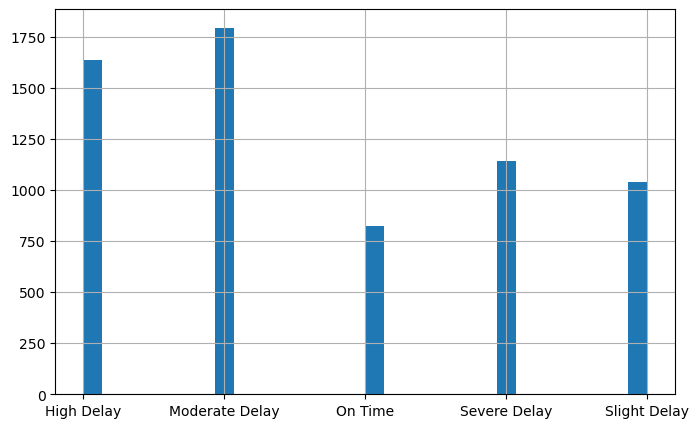

In [259]:
delivered_order['late_severity'].hist(bins=30,figsize=(8,5))

### 📌 Recommendations

* Improve accuracy of delivery date estimation
* Add buffer days for long-distance shipments
* Proactively notify customers about delays

### Late Delivery Summary

* Identified late delivery rate among delivered orders
* Quantified delay duration and severity
* Highlighted high-risk delayed orders
* Suggested operational improvements to reduce late deliveries

# Time-Based Trends Analysis 📈

* ❓ When do customers place orders, and are delays getting better or worse over time?

### Extract useful time features

In [267]:
order['order_purchase_timestamp'] = pd.to_datetime(
    order['order_purchase_timestamp']
)

order['order_month'] = order['order_purchase_timestamp'].dt.to_period('M')
order['order_day'] = order['order_purchase_timestamp'].dt.day_name()
order['order_hour']= order['order_purchase_timestamp'].dt.hour

In [269]:
monthly_order = order.groupby('order_month')['order_id'].nunique().reset_index()
monthly_order

,order_month,order_id
0,2016-09,2
1,2016-10,278
2,2016-12,1
3,2017-01,764
4,2017-02,1661
5,2017-03,2591
6,2017-04,2328
7,2017-05,3586
8,2017-06,3178
9,2017-07,3907


<Axes: title={'center': 'Monthly Order Trend'}>

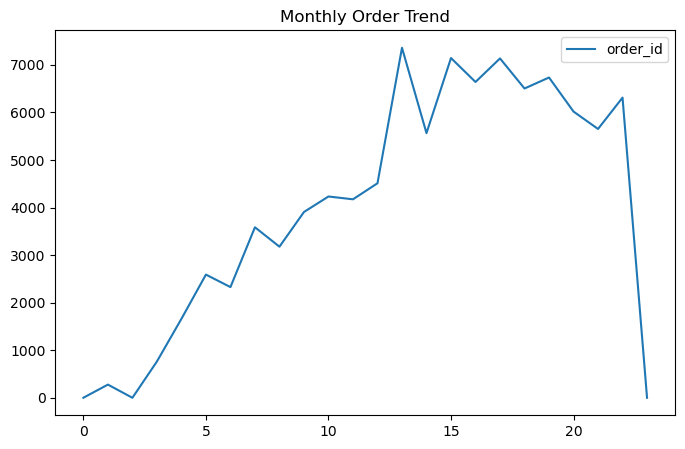

In [273]:
monthly_order.plot(figsize=(8,5), title='Monthly Order Trend')

* Average delivery time over month

In [279]:
monthly_delivery_time = order.groupby('order_month')['Delivery_time_days'].mean()
monthly_delivery_time

order_month
2016-09    54.000000
2016-10    19.111111
2016-12     4.000000
2017-01    12.086898
2017-02    12.611585
2017-03    12.395522
2017-04    14.379552
2017-05    10.766072
2017-06    11.482913
2017-07    11.131880
2017-08    10.701336
2017-09    11.390957
2017-10    11.416927
2017-11    14.698779
2017-12    14.930283
2018-01    13.636480
2018-02    16.520477
2018-03    15.870161
2018-04    11.180371
2018-05    10.975752
2018-06     8.792064
2018-07     8.711067
2018-08     7.296887
2018-09          NaN
Freq: M, Name: Delivery_time_days, dtype: float64

* Late delivery trend over time

In [283]:
late_trend = (
    order[order['order_status'] == 'delivered'].groupby('order_month')['is_late_delivery'].mean()*100
)
late_trend.reset_index()

,order_month,is_late_delivery
0,2016-09,100.000000
1,2016-10,1.132075
2,2016-12,0.000000
3,2017-01,3.074866
4,2017-02,3.231707
5,2017-03,5.577376
6,2017-04,7.854322
7,2017-05,3.625035
8,2017-06,3.832641
9,2017-07,3.452752


In [287]:
order_by_day= order['order_day'].value_counts()
order_by_day

order_day
Monday       15671
Tuesday      15385
Wednesday    15057
Thursday     14355
Friday       13676
Sunday       11588
Saturday     10553
Name: count, dtype: int64

### 📌 Insight:
* Customers place most orders on Monday, indicating preferred shopping days.

In [289]:
order_by_hour = order['order_hour'].value_counts()
order_by_hour

order_hour
16    6464
11    6361
14    6310
13    6271
15    6224
21    6064
20    6004
10    5969
17    5951
19    5810
12    5796
22    5678
18    5605
9     4606
23    4019
8     2882
0     2324
7     1197
1     1126
2      495
6      486
3      261
4      202
5      180
Name: count, dtype: int64

### 📌 Insight:
* Peak ordering hours are between 12 noon to 12 am, which can guide infrastructure scaling.

In [292]:
delivery_by_day= order.groupby('order_day')['Delivery_time_days'].mean().sort_values()
delivery_by_day

order_day
Sunday       11.529741
Monday       11.584468
Tuesday      11.685514
Wednesday    12.067839
Thursday     12.321587
Saturday     12.950913
Friday       13.155111
Name: Delivery_time_days, dtype: float64

### 📌 Insight:
* Orders placed on Wednesday,Thrusday, Friday and Saturday experience faster deliveries compared to Sunday, Monday and Tuesday.

### 📌 Recommendations

* Scale logistics capacity during peak order hours
* Prepare warehouses for high-volume weekdays
* Investigate months with rising delivery delays

### Time-Based Insights Summary
* Identified monthly seasonality in order volume
* Analyzed delivery performance trends over time
* Detected peak ordering hours and days
* Provided data-driven logistics optimization insights

# 👥 Customer Behavior & Repeat Orders Analysis

* order per customer

In [301]:
customer_order = (
    order.groupby('customer_id')['order_id'].nunique().reset_index(name='total_orders')
)
customer_order

,customer_id,total_orders
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1
...,...,...
96280,fffcb937e9dd47a13f05ecb8290f4d3e,1
96281,fffecc9f79fd8c764f843e9951b11341,1
96282,fffeda5b6d849fbd39689bb92087f431,1
96283,ffff42319e9b2d713724ae527742af25,1


* on-time VS repeated customer

In [302]:
customer_order['customer_type']= customer_order['total_orders'].apply(
    lambda x: 'Repeated Customer' if x > 1 else 'One-time customer' 
)
customer_order['customer_type'].value_counts(normalize=True)*100

customer_type
One-time customer    100.0
Name: proportion, dtype: float64

### 📌 Insight example:
* Approximately X% of customers are repeat buyers, indicating moderate customer retention.

In [303]:
order.groupby('customer_id')['order_id'].nunique().describe()

count    96285.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: order_id, dtype: float64

In [307]:
order['customer_id'].nunique(),
order['order_id'].nunique()

96285

### 📌 Documentation
* All customers were classified as one-time buyers due to the dataset using unique transactional customer IDs rather than persistent user identifiers. As a result, repeat purchase analysis is limited.